In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#setup
T = 4.0               #tempo de simulação
dt = 0.0001           #passo
t = np.arange(0,T,dt) #vetor de tempo
t_len = len(t)        #quantidade de instantes de tempo

In [3]:
#elastancia setup
Emax = 2
Emin = 0.06
HR = 60
tc = 60 / HR
Tmax = 0.2 + 0.15*tc

In [4]:
#resistences
Rs = 1.0000
Rm = 0.0050
Ra = 0.0010
Rc = 0.0398

#compliances
#C(t) variável no tempo
Cr = 4.4000
Cs = 1.3300
Ca = 0.0800

#inertances
Ls = 0.0005

V0 = 10

In [5]:
#condições iniciais
x = np.empty(t_len);   x[0] = -1
y = np.empty(t_len);   y[0] = 0
z = np.empty(t_len);   z[0] = 0

Pae = np.zeros(t_len); Pae[0] = 5  
Vve = np.zeros(t_len); Vve[0] = 140 
Pao = np.zeros(t_len); Pao[0] = 90
Q   = np.zeros(t_len); Q  [0] = 0
Pas = np.zeros(t_len); Pas[0] = 90
Pve = np.zeros(t_len)

In [6]:
#cada linha da tabela corresponde a (P, Q, R, S, T)
ECG_Table = [[(-1/3)*np.pi, (-1/12)*np.pi,    0, (1/12)*np.pi, (1/2)*np.pi],
            [          1.2,          -5.0, 30.0,         -7.5,        0.75],
            [         0.25,           0.1,  0.1,          0.1,         0.4]]

table_width = 5

In [7]:
def Elastancia(t, k):

    tn = []
    En = []
    
    for i in range(int(tc/dt)):
 
        if i+k == len(t): # i+k corresponde à posição atual em relação ao tempo
            break
        t_aux = t[i] % tc # repete o ciclo cardíaco
        tn.append(t_aux/Tmax)

        v1 = (tn[-1]/0.7)**1.9
        v2 = 1 + v1
        v3 = 1 + (tn[-1]/1.17)**21.9

        En.append(1.55*(v1/v2)*(1/v3))
        
    return En, int((tc/dt)+k)

In [8]:
def ECG():

    #definindo variáveis da função elastância de Simaan
    En = []
    EnAux = []
    deltaK = 0 # valor de tempo onde a função elastância termina
    rWaveCount = 0 # contador de ondas R

    for i in range(t_len-1):
        
        alfa = 1.0 - np.sqrt(x[i]**2 + y[i]**2)
        omega = 2*np.pi/tc
        
        #Resolvendo as EDO'S
        x[i+1] = x[i] + dt*(alfa*x[i] - omega*y[i])
        y[i+1] = y[i] + dt*(alfa*y[i] + omega*x[i])
        
        theta = np.arctan2(y[i], x[i])
        sum = 0

        for colum in range(table_width):
            deltaTheta_i = (theta - ECG_Table[0][colum]) 
            sum += ECG_Table[1][colum]*deltaTheta_i*np.exp(-(deltaTheta_i**2)/(2*(ECG_Table[2][colum]**2)))

        z[i+1] = z[i] + dt*(-sum - z[i])

        # inserção da função elastância
        if(z[i+1] >= 0.02 and rWaveCount <= t[i]//tc):
            EnAux, deltaK = Elastancia(t, i)
            En += EnAux
            rWaveCount += 1
        elif deltaK <= i:
            En.append(0)

    E = (Emax - Emin)*np.array(En) + Emin
    Pve[0] = (Vve[0] - V0)*E[0]
    
    #o próximo ponto é igual ao ponto anterior somado ao passo de integração multiplicado pelo modelo da variável de estado
    for i in range(len(t)-1):

        Dm = (1 if Pae[i] >= Pve[i] else 0)
        Da = (1 if Pve[i] >= Pao[i] else 0)

        Vve[i+1] = Vve[i]  +dt*( (Da/Ra)*Pao[i] - (Dm/Rm + Da/Ra)*E[i]*Vve[i] + (Dm/Rm)*Pae[i] + (Dm/Rm + Da/Ra)*E[i]* V0)
        Pve[i+1] = E[i+1]*(Vve[i+1] - V0)

        Pae[i+1] = Pae[i]  +dt*(-(Dm/(Cr*Rm))*(Pae[i] - Pve[i]) + (Pas[i]-Pae[i])/(Cr*Rs))
        Pao[i+1] = Pao[i]  +dt*((Da/(Ca*Ra))*(Pve[i] - Pao[i]) - Q[i]/Ca)
        Q  [i+1] =   Q[i]  +dt*((-(Rc*Q[i])/Ls) - (Pas[i]/Ls) + (Pao[i]/Ls))
        Pas[i+1] = Pas[i]  +dt*((Q[i]/Cs) - (Pas[i]-Pae[i])/(Cs*Rs))
  
    return z, E

In [9]:
ECGR, E = ECG()

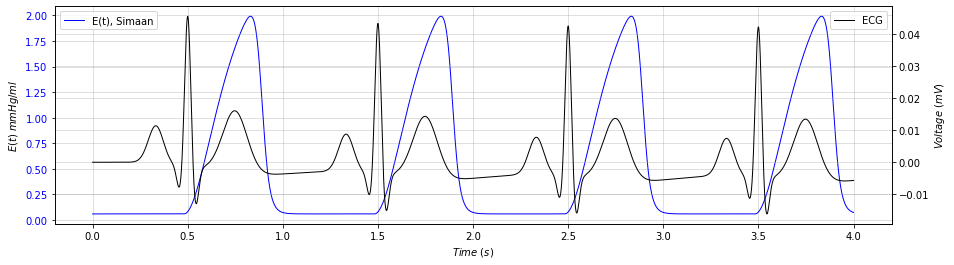

In [10]:
fig, ax1 = plt.subplots(figsize=(15,4))
ax1.plot(t ,E, c = 'blue', lw = '1', label = 'E(t), Simaan')
ax1.grid(alpha = 0.5)
ax1.set_xlabel('$Time$ $(s)$')
ax1.set_ylabel('$E(t)$ $mmHg/ml$')
ax1.legend(loc="upper left")
ax1.tick_params(axis='y', labelcolor = 'blue')

ax2 = ax1.twinx()
ax2.plot(t, ECGR, c = 'black', lw = '1', label = 'ECG')
ax2.grid(alpha = 0.5)
ax2.set_ylabel('$Voltage$ $(mV)$', c = 'black')
ax2.tick_params(axis='y', labelcolor = 'black')

plt.legend()
plt.show()

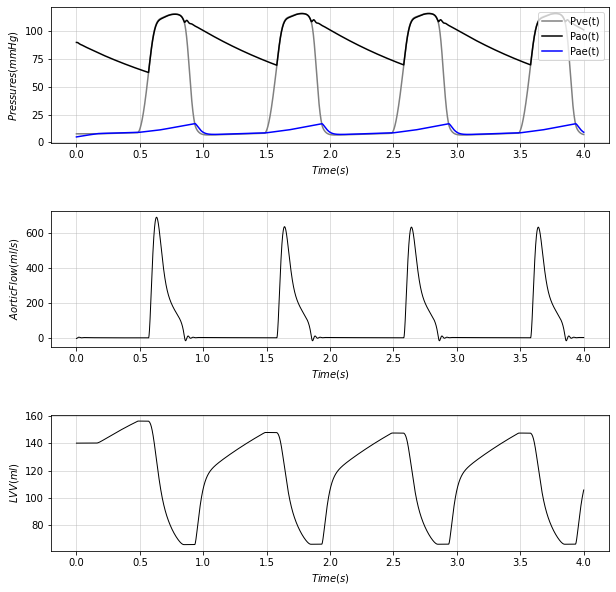

In [11]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3, 1, 1)
plt.plot(t, Pve, c = 'gray', lw = 1.5, label = 'Pve(t)')
plt.plot(t, Pao, c = 'k', lw = 1.5, label = 'Pao(t)')
plt.plot(t, Pae, c = 'b', lw = 1.5, label = 'Pae(t)')
plt.legend(loc="upper right")
plt.grid(alpha = 0.5)
plt.ylabel('$Pressures (mmHg)$')
plt.xlabel('$Time(s)$')

plt.subplot(3, 1, 2)
plt.plot(t, Q, c = 'k', lw = 1)
plt.grid(alpha = 0.5)
plt.ylabel('$Aortic Flow (ml/s)$')
plt.xlabel('$Time(s)$')

plt.subplot(3, 1, 3)
plt.plot(t, Vve, c = 'k', lw = 1)
plt.grid(alpha = 0.5)
plt.ylabel('$LVV (ml)$')
plt.xlabel('$Time(s)$')

plt.show()